In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Activation, BatchNormalization, Dropout, Dot, Add, Flatten, Dense

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline




### READING ANIME LIST.csv

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..", "artifacts","raw")



In [4]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])


In [5]:
rating_df.head()


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)




5000000

###Data Preprocessing


In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()






In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])







In [10]:
avg_rating = rating_df["rating"].mean()


In [11]:
max_rating


10

In [12]:
# min max scaler

rating_df["rating"] = rating_df["rating"].apply(lambda X: (X - min_rating) / (max_rating - min_rating)).values.astype(np.float64)


In [13]:
rating_df.isnull().sum()



user_id     0
anime_id    0
rating      0
dtype: int64

In [14]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x: i for i , x in enumerate(user_ids)}
user2user_decoded = {i: x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [15]:
n_users = len(user2user_encoded)


In [16]:
n_users

4203

In [17]:
#### USER ---> 10054 ----> 98


In [18]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [19]:
n_anime = len(anime2anime_encoded)


In [20]:
n_anime


17149

In [21]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)


In [22]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values



In [23]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]






In [24]:
X_train


array([[3405,  688],
       [4060, 1518],
       [1213, 4963],
       ...,
       [ 560, 1461],
       [3815, 1512],
       [2122, 1153]])

In [25]:
len(X_test)


1000

In [26]:
type(X_train)


numpy.ndarray

In [27]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]   


In [28]:
type(X_train_array)


list

In [29]:
type(X_test_array[0])


numpy.ndarray

#### MOODEL ARCHITECTURE

In [30]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product",normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model([user, anime], x)
    model.compile(loss="binary_crossentropy",metrics=["mae", "mse"], optimizer=Adam(learning_rate=0.001))

    return model


In [31]:
model  = RecommenderNet()

model.summary()






Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [32]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr






In [33]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint= ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",patience=3,mode="min",restore_best_weights=True)








In [34]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]


In [35]:
history = model.fit(X_train_array, y_train, batch_size=batch_size, epochs=20,verbose=1, validation_data=(X_test_array, y_test), callbacks=my_callbacks)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.7052 - mae: 0.3635 - mse: 0.1613 - val_loss: 0.6925 - val_mae: 0.3632 - val_mse: 0.1566 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.7034 - mae: 0.3631 - mse: 0.1605 - val_loss: 0.6941 - val_mae: 0.3636 - val_mse: 0.1574 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 0.7006 - mae: 0.3622 - mse: 0.1592 - val_loss: 0.6963 - val_mae: 0.3639 - val_mse: 0.1585 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 0.6970 - mae: 0.3610 - mse: 0.1573 - val_loss: 0.6949 - val_mae: 0.3635 - val_mse: 0.1578 - learning_rate: 3.4000e-05


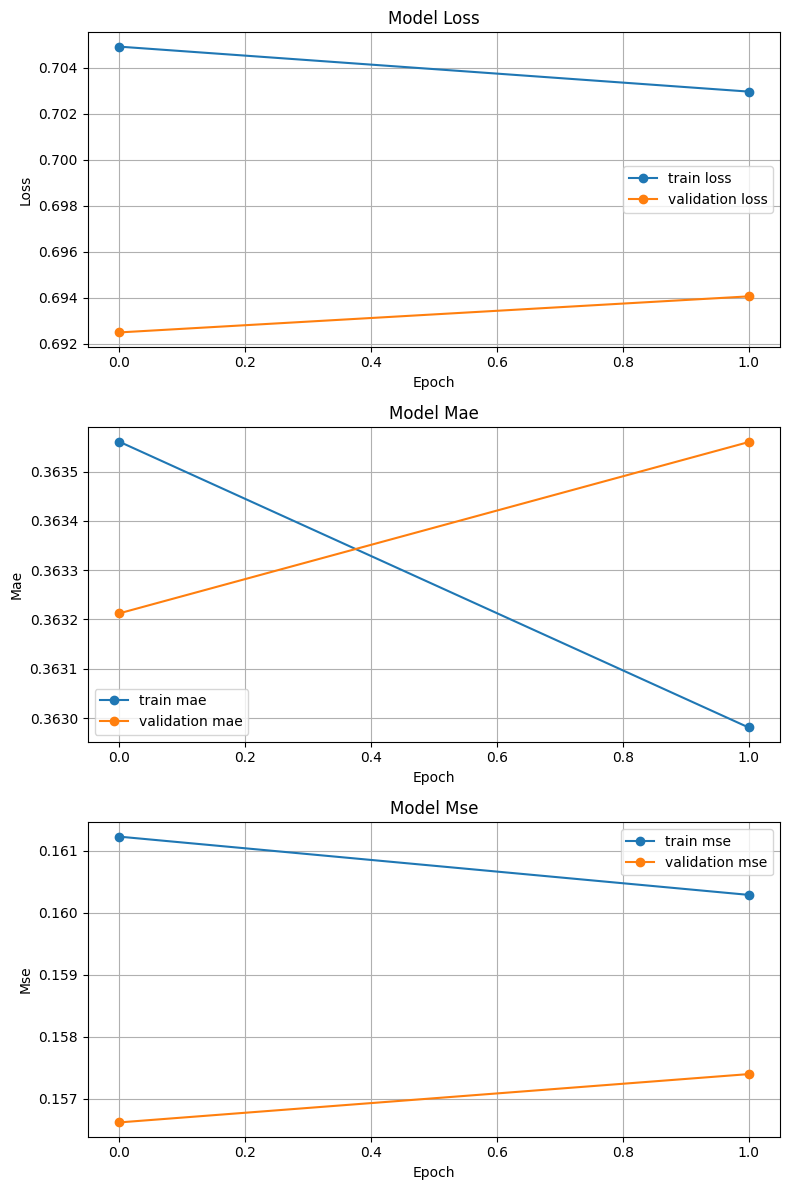

In [36]:
metrics = ["loss", "mae", "mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,4*len(metrics)))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"validation {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="best")
    ax.grid(True)
plt.tight_layout()
plt.show()




In [37]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    
    return weights







In [38]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)







#### READING ANIME>CSV``

In [39]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True,)


In [40]:
df.head()


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [41]:
df = df.replace("Unknown", np.nan)


In [42]:
def getAmineName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name


In [43]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAmineName(x))


In [44]:
df.head()



,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [45]:
getAmineName(67)


'Basilisk'

In [46]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last",
               )


In [47]:
df.head()


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [48]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [49]:
df = df[["anime_id", "eng_version","Score", "Genres", "Episodes", "Type","Premiered","Members"]]

In [50]:
df.head()


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [51]:
def getAnimeFrame(anime,df):
    try:
        if isinstance(anime,int):
            return df[df["anime_id"] == anime]
        elif isinstance(anime,str):
            return df[df["eng_version"] == anime]
        else:
            raise ValueError("Invalid input")
    except:
        print("Error")
        return None







In [52]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [53]:
getAnimeFrame("Fullmetal Alchemist", df)



,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
100,121,Fullmetal Alchemist,8.17,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",51,TV,Fall 2003,1151621


#### ANIME WITH SYNOPSIS>CSV

In [54]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]


In [55]:
synopsys_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", low_memory=True, usecols=cols)


In [56]:
synopsys_df.head()


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [57]:
def getSynopsis(anime_id):
    try:
        if isinstance(anime_id,int):
            return synopsys_df[synopsys_df["MAL_ID"] == anime_id].sypnopsis.values[0]
        elif isinstance(anime_id,str):
            return synopsys_df[synopsys_df["Name"] == anime_id].sypnopsis.values[0]
        else:
            raise ValueError("Invalid input")
    except:
        print("Error")
        return None
        


In [58]:
getSynopsis("Fullmetal Alchemist")


"Edward Elric, a young, brilliant alchemist, has lost much in his twelve-year life: when he and his brother Alphonse try to resurrect their dead mother through the forbidden act of human transmutation, Edward loses his brother as well as two of his limbs. With his supreme alchemy skills, Edward binds Alphonse's soul to a large suit of armor. A year later, Edward, now promoted to the fullmetal alchemist of the state, embarks on a journey with his younger brother to obtain the Philosopher's Stone. The fabled mythical object is rumored to be capable of amplifying an alchemist's abilities by leaps and bounds, thus allowing them to override the fundamental law of alchemy: to gain something, an alchemist must sacrifice something of equal value. Edward hopes to draw into the military's resources to find the fabled stone and restore his and Alphonse's bodies to normal. However, the Elric brothers soon discover that there is more to the legendary stone than meets the eye, as they are led to the

In [59]:
synopsys_df.head()


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


#### CONTENT/ITEM BASED RECOMMENDATION


In [60]:
pd.set_option("max_colwidth", None)


In [61]:
def find_similar_animes(name, anime_weights, anime2anime_encoded,
                        anime2anime_decoded, df, synopsys_df,
                        n=10, return_dist=False,
                        neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Anime ID {index} not found in encoding.")

        dists = np.dot(anime_weights, anime_weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists, closest

        similarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            if decoded_id is None:
                continue

            synopsis = getSynopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id, df)

            if anime_frame.empty:
                continue

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            similarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })

        Frame = pd.DataFrame(similarityArr).sort_values(by="similarity", ascending=False)

        return Frame[Frame.anime_id != index].drop("anime_id", axis=1)

    except Exception as e:
        print(f"Error Occurred: {e}")


In [62]:
find_similar_animes("Fullmetal Alchemist",anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsys_df,n=2)


Anime closest to Fullmetal Alchemist


,name,similarity,genre,synopsis
1,Keishichou Tokumubu Tokushu Kyouakuhan Taisakushitsu Dainanaka: Tokunana Recap,0.381218,"Action, Fantasy, Police, Vampire",cap of first eight episodes of Keishichou Tokumubu Tokushu Kyouakuhan Taisakushitsu Dainanaka: Tokunana .
2,Line Offline: Salaryman,0.321226,Comedy,"The anime shorts are set in the fictional Line Corporation with a motley crew of idiosyncratic workers. There is the narcissistic section head and president's son James, the subsection head Moon (who is always gone somewhere but somehow gets his work done), the quiet but kindhearted subsection head Brown, and the subordinate Connie who is in an endless loop of yo-yo diets and weight gains. (Source: ANN)"


#### USER BASED RECOMMENDATION- COLLABORATIVE FILTERING


In [63]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, 
                       n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"User ID {index} not found in encoded dictionary.")

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1  # include self

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        if return_dist:
            return dists, closest

        similarityArr = []
        for close in closest:
            similarity = dists[close]
            decoded_id = user2user_decoded.get(close)

            if decoded_id is None:
                print(f"Warning: user2user_decoded missing index {close}")
                continue

            if decoded_id != index:
                similarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        if not similarityArr:
            raise ValueError("No similar users found — similarityArr is empty.")

        similar_users = pd.DataFrame(similarityArr).sort_values(by="similarity", ascending=False)
        return similar_users

    except Exception as e:
        print(f"Error Occurred: {e}")


In [64]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded, n=10)


,similar_users,similarity
0,3702,0.310255
1,1893,0.285555
2,11988,0.280909
3,11342,0.271966
4,8343,0.257580
5,5579,0.255553
6,2088,0.255207
7,5234,0.252883
8,2595,0.252396
9,9471,0.248413


In [65]:
def showWordCloud(all_genres):
    # Convert defaultdict to a single string
    genre_string = " ".join([genre for genre, count in all_genres.items() for _ in range(count)])

    genre_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot2").generate(genre_string)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(genre_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [66]:
from collections import defaultdict


In [67]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []

    for genre in frame["Genres"]:
        if isinstance(genre, str):
            for g in genre.split(","):
                all_genres[g.strip()] += 1
                genres_list.append(g)

    if plot:
        showWordCloud(all_genres)

    return genres_list







In [68]:
x = getAnimeFrame(1,df)

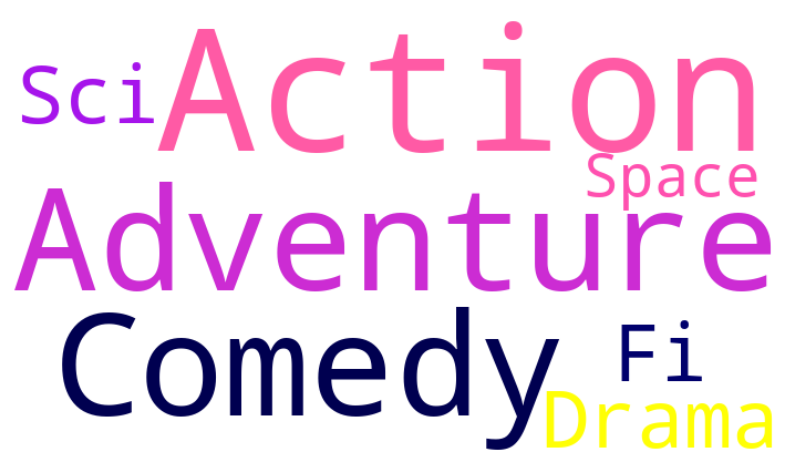

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [69]:
getFavGenre(x,
           plot=True,
           )


In [70]:
rating_df.head(2)


,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518


In [71]:
def get_user_preferences(user_id, rating_df,df,verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df["user_id"] == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user["rating"], 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user["rating"] >= user_rating_percentile]

    top_animes_by_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_by_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        fav_genres = getFavGenre(anime_df_rows, plot=plot)


    if verbose:
        print(f"User {user_id} has watched {len(animes_watched_by_user)} animes with rating greater than {user_rating_percentile}")

    return anime_df_rows



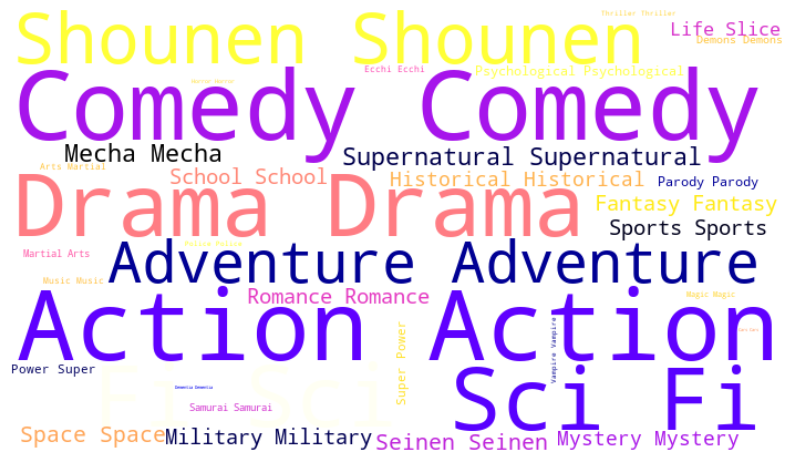

User 11880 has watched 190 animes with rating greater than 0.8


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [72]:
get_user_preferences(11880, rating_df, df, verbose=1, plot=True)


#### USER BASED RECOMMENDATION


In [82]:
def get_user_recommendations(similar_users, user_pref, df, synopsys_df,rating_df,n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users["similar_users"].values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)

                anime_id = frame.anime_id.values[0]
                genre =frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id))

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "genre": genre,
                    "synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)












In [83]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded, n=10)


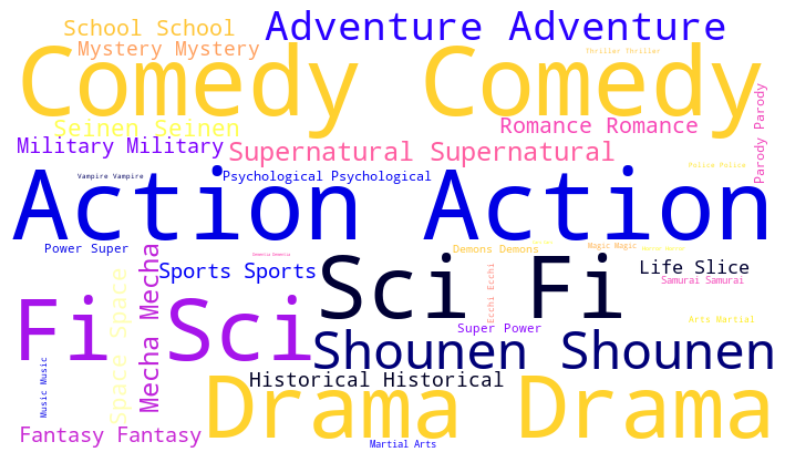

User 11880 has watched 190 animes with rating greater than 0.8


In [84]:
user_pref = get_user_preferences(11880, rating_df, df, verbose=1, plot=True)


In [85]:
get_user_recommendations(similar_users, user_pref, df, synopsys_df, rating_df, n=2)


,n,anime_name,genre,synopsis
0,12,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects."
1,8,Sword Art Online,"Action, Game, Adventure, Romance, Fantasy","In the year 2022, virtual reality has progressed by leaps and bounds, and a massive online role-playing game called Sword Art Online (SAO) is launched. With the aid of ""NerveGear"" technology, players can control their avatars within the game using nothing but their own thoughts. Kazuto Kirigaya, nicknamed ""Kirito,"" is among the lucky few enthusiasts who get their hands on the first shipment of the game. He logs in to find himself, with ten-thousand others, in the scenic and elaborate world of Aincrad, one full of fantastic medieval weapons and gruesome monsters. However, in a cruel turn of events, the players soon realize they cannot log out; the game's creator has trapped them in his new world until they complete all one hundred levels of the game. In order to escape Aincrad, Kirito will now have to interact and cooperate with his fellow players. Some are allies, while others are foes, like Asuna Yuuki, who commands the leading group attempting to escape from the ruthless game. To make matters worse, Sword Art Online is not all fun and games: if they die in Aincrad, they die in real life. Kirito must adapt to his new reality, fight for his survival, and hopefully break free from his virtual hell."


#### HYBRID RECOMMENDER SYSTEM

In [90]:
def hybrid_recommendation(
    user_id,
    cf_weight: float = 0.5,     # collaborative‐filtering blend‐weight
    cb_weight: float = 0.5      # content‐based blend‐weight
):
    # inside, use the GLOBAL embedding matrices:
    # user_weights  ← your 2D numpy array of user embeddings
    # anime_weights ← your 2D numpy array of anime embeddings

    # 1) Collaborative filtering:
    similar_users = find_similar_users(
        user_id,
        user_weights,             # ← the matrix!
        user2user_encoded,
        user2user_decoded,
        n=10
    )
    if similar_users is None or similar_users.empty:
        print("No similar users found. Returning empty recommendation.")
        return []

    # 2) This user’s own preferences:
    user_pref = get_user_preferences(user_id, rating_df, df)

    # 3) User‐based recommendations:
    user_recs = get_user_recommendations(
        similar_users,
        user_pref,
        df,
        synopsys_df,
        rating_df,
        n=10
    )
    if user_recs is None or user_recs.empty:
        print("No user-based recommendations found.")
        return []

    user_list = user_recs["anime_name"].tolist()

    # 4) Content‐based recommendations on those:
    content_list = []
    for anime in user_list:
        sim_animes = find_similar_animes(
            anime,
            anime_weights,          # ← the matrix!
            anime2anime_encoded,
            anime2anime_decoded,
            df,
            synopsys_df,
            n=10
        )
        if sim_animes is not None and not sim_animes.empty:
            content_list.extend(sim_animes["name"].tolist())

    # 5) Combine scores using the *floats* cf_weight & cb_weight
    combined = {}
    for a in user_list:
        combined[a] = combined.get(a, 0) + cf_weight
    for a in content_list:
        combined[a] = combined.get(a, 0) + cb_weight

    # 6) Top‐10
    sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)
    return [anime for anime, _ in sorted_items[:10]]


In [94]:
hybrid_recommendation(
    user_id=459,
    cf_weight=0.6,
    cb_weight=0.4
)


Anime closest to GATE
Anime closest to No Game, No Life
Error
Anime closest to Re:ZERO -Starting Life in Another World-
Anime closest to Your Name.
Anime closest to Made in Abyss
Error
Error
Anime closest to Sword Art Online
Error
Anime closest to anohana:The Flower We Saw That Day
Anime closest to Angel Beats!
Anime closest to Toradora!
Error
Anime closest to A Silent Voice
Error
Error


['GATE',
 'No Game, No Life',
 'Re:ZERO -Starting Life in Another World-',
 'Your Name.',
 'Made in Abyss',
 'Sword Art Online',
 'anohana:The Flower We Saw That Day',
 'Angel Beats!',
 'Toradora!',
 'A Silent Voice']